In [218]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


##Word-Document and Word-Word Matrices

In [182]:
# Example documents (Shakespeare plays)
documents = {
    "As You Like It": "battle good fool wit love forest magic",
    "Twelfth Night": "good fool wit love comedy mistaken identity",
    "Julius Caesar": "battle battle battle good fool war rome politics",
    "Henry V": "battle battle battle battle good wit war king england"
}

In [183]:
def create_term_document_matrix(documents):
  """ Creates term-document matrix
  Rows represent words (terms)
  Columns represent docs
  Cells have the frequencies (counts)"""

  all_the_words = set()

  for doc in documents.values():
    all_the_words.update(doc.split())

  vocab = sorted(all_the_words)
  print(vocab)

  matrix = []

  for word in vocab:
    row = []

    for doc_name, doc_text in documents.items():
      count = doc_text.split().count(word)
      row.append(count)

    matrix.append(row)

  print(matrix)


  df = pd.DataFrame(matrix,
                    index=vocab,
                    columns=list(documents.keys()))

  return df

term_doc_matrix = create_term_document_matrix(documents)
print("\n", term_doc_matrix)

['battle', 'comedy', 'england', 'fool', 'forest', 'good', 'identity', 'king', 'love', 'magic', 'mistaken', 'politics', 'rome', 'war', 'wit']
[[1, 0, 3, 4], [0, 1, 0, 0], [0, 0, 0, 1], [1, 1, 1, 0], [1, 0, 0, 0], [1, 1, 1, 1], [0, 1, 0, 0], [0, 0, 0, 1], [1, 1, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 1], [1, 1, 0, 1]]

           As You Like It  Twelfth Night  Julius Caesar  Henry V
battle                 1              0              3        4
comedy                 0              1              0        0
england                0              0              0        1
fool                   1              1              1        0
forest                 1              0              0        0
good                   1              1              1        1
identity               0              1              0        0
king                   0              0              0        1
love                   1              1              0        0
magic 

## TF-IDF


In [184]:
def compute_tf_idf(term_doc_matrix):
  """Compute Term Frequency × Inverse Document Frequency"""

  matrix = term_doc_matrix.values # Convert to numpy.ndarray to apply np.where easily

  n_docs = matrix.shape[1]

  print(np.where(matrix>0, 1,0))

  # Term freq
  tf = np.where(matrix > 0, 1 + np.log10(matrix + 1e-10), 0) # Raw counts can be misleading (100 occurrences isn't 100x more important than 1), for taht reason we compress it with the log10. Also, added small epsilon to avoid log(0) and warning
  print("\nTerm Freq:\n", tf, "\n")

  # Doc freq (words appearing on how many docs)
  df = np.sum(matrix>0, axis=1)
  print("\nDoc Freq:\n", df, "\n")

  # Inverse doc freq
  idf = np.log10(n_docs/df)
  print("\nInverse Doc Freq without log(10):\n", n_docs/df, "\n")

  print("\nInverse Doc Freq (with log(10)):\n", idf, "\n")


  # TF-IDF
  idf = idf[:, np.newaxis] # Flatten idf
  print("\nBroadcasted Inverse Doc Freq to dimensionality (n,1):\n", idf, "\n")

  tf_idf = tf*idf
  print("\nTF-IDF:\n", idf, "\n")

  return pd.DataFrame(tf_idf, index=term_doc_matrix.index, columns=term_doc_matrix.columns)

tf_idf_matrix = compute_tf_idf(term_doc_matrix)
tf_idf_matrix

[[1 0 1 1]
 [0 1 0 0]
 [0 0 0 1]
 [1 1 1 0]
 [1 0 0 0]
 [1 1 1 1]
 [0 1 0 0]
 [0 0 0 1]
 [1 1 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 1]
 [1 1 0 1]]

Term Freq:
 [[1.         0.         1.47712125 1.60205999]
 [0.         1.         0.         0.        ]
 [0.         0.         0.         1.        ]
 [1.         1.         1.         0.        ]
 [1.         0.         0.         0.        ]
 [1.         1.         1.         1.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.         1.        ]
 [1.         1.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         1.        ]
 [1.         1.         0.         1.        ]] 


Doc Freq:
 [3 1 1 3 1 4 1 1 2 1 1 1 1 2 3] 


Inverse Doc Freq without log(10):
 [1.33333333 4.         4.      

,As You Like It,Twelfth Night,Julius Caesar,Henry V
battle,0.124939,0.000000,0.184550,0.200159
comedy,0.000000,0.602060,0.000000,0.000000
england,0.000000,0.000000,0.000000,0.602060
fool,0.124939,0.124939,0.124939,0.000000
forest,0.602060,0.000000,0.000000,0.000000
good,0.000000,0.000000,0.000000,0.000000
identity,0.000000,0.602060,0.000000,0.000000
king,0.000000,0.000000,0.000000,0.602060
love,0.301030,0.301030,0.000000,0.000000
magic,0.602060,0.000000,0.000000,0.000000


## Word-Word Co-occurrence (Association)


In [185]:
def create_word_cooccurrence_matrix(documents, window_size=2):
  cooccurrence = defaultdict(lambda: defaultdict(int))

  for doc in documents.values():
    words = doc.split()

    for i, target_word in enumerate(words):# print(i,target_word)

      start = max(0, i - window_size) # Sets the start of the context window so it is not below 0
      end = min(len(words), i + window_size + 1) # Sets the end of the context window so it is not above the last word
      print("Word ", target_word, "has a window with indexes range ", start, "-", end, "\n")

      for j in range(start,end):
        if i != j:                  # Not counting the word with itself

          context_word = words[j]
          cooccurrence[target_word][context_word] += 1

      print("cooccurrence: ", cooccurrence)


  # all_words = []
  # for doc in documents.values():
  #   for word in doc.split(): all_words.append(word)
  # sorted(set(all_words))

  all_words = sorted(set(word for doc in documents.values() for word in doc.split(" ")  )) # Same as above but in a set comprehension
  print("\nall_words: ", all_words)

  matrix = []
  for target_word in all_words:
    row = []
    for ctxt_word in all_words:
      row.append(cooccurrence[target_word][ctxt_word])
    matrix.append(row)

  return pd.DataFrame(matrix, index = all_words, columns = all_words)

cooc_matrix = create_word_cooccurrence_matrix(documents, window_size=2)
cooc_matrix

Word  battle has a window with indexes range  0 - 3 

cooccurrence:  defaultdict(<function create_word_cooccurrence_matrix.<locals>.<lambda> at 0x79faf6e99da0>, {'battle': defaultdict(<class 'int'>, {'good': 1, 'fool': 1})})
Word  good has a window with indexes range  0 - 4 

cooccurrence:  defaultdict(<function create_word_cooccurrence_matrix.<locals>.<lambda> at 0x79faf6e99da0>, {'battle': defaultdict(<class 'int'>, {'good': 1, 'fool': 1}), 'good': defaultdict(<class 'int'>, {'battle': 1, 'fool': 1, 'wit': 1})})
Word  fool has a window with indexes range  0 - 5 

cooccurrence:  defaultdict(<function create_word_cooccurrence_matrix.<locals>.<lambda> at 0x79faf6e99da0>, {'battle': defaultdict(<class 'int'>, {'good': 1, 'fool': 1}), 'good': defaultdict(<class 'int'>, {'battle': 1, 'fool': 1, 'wit': 1}), 'fool': defaultdict(<class 'int'>, {'battle': 1, 'good': 1, 'wit': 1, 'love': 1})})
Word  wit has a window with indexes range  1 - 6 

cooccurrence:  defaultdict(<function create_word_co

,battle,comedy,england,fool,forest,good,identity,king,love,magic,mistaken,politics,rome,war,wit
battle,16,0,0,2,0,5,0,0,0,0,0,0,0,0,1
comedy,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1
england,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
fool,2,0,0,0,0,3,0,0,2,0,0,0,1,1,2
forest,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
good,5,0,0,3,0,0,0,0,0,0,0,0,0,2,3
identity,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
king,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
love,0,1,0,2,1,0,0,0,0,1,1,0,0,0,2
magic,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


## PPMI (Positive Pointwise Mutual Information)

In [186]:
def compute_ppmi(cooc_matrix, alpha = 0.75):
  """
  Compute PPMI matrix from the Co-occurrence matrix.
  alpha = 0.75: Levy et al. (2015) found that a setting of α = 0.75 improved performance of embeddings on a wide range of tasks
  0.75 increases the probability assigned to rare contexts, and hence lowers their PMI (Pα(c) > P(c) when c is rare).
  """

  matrix = cooc_matrix.values.astype(float)

  total = np.sum(matrix)


  # Joint probabilities P(w,c)
  # Element-wise division by scalar
  p_wc = matrix / total
  print("\n p_wc: \n", p_wc, "\n")

  # Getting marginal probabilities
  p_w = np.sum(matrix, axis=1) / total
  p_c = np.sum(matrix, axis=0) / total # Although it is the same bcs it is a symmetric co-occurrence matrix


  # Smoothing and re-normalizing
  p_c_alpha = np.power(p_c, alpha)
  p_c_alpha = p_c_alpha / np.sum(p_c_alpha)

  for i,j,k in zip(cooc_matrix.index, p_w, p_c_alpha):print(i,j,round(k,4)) ## p_w = p_c because it is a symmetric matrix, with the power to alpha that changes


  # Calculate PMI
  epsilon = 1e-10 #Added small epsilon to avoid division by zero and log(0)

  pmi = np.log2((p_wc + epsilon)/
              (p_w[:,np.newaxis] * p_c_alpha[np.newaxis,:]+epsilon)) # Broadcasting p_w to dimension (1,n)
  print("\n PMI: \n", pmi, "\n")

  # Convert to PPMI (turn negatives to zero)
  ppmi = np.maximum(0,pmi)
  return pd.DataFrame(ppmi, index=cooc_matrix.index, columns=cooc_matrix.columns)

compute_ppmi(cooc_matrix, alpha = 0.75)


 p_wc: 
 [[0.16 0.   0.   0.02 0.   0.05 0.   0.   0.   0.   0.   0.   0.   0.
  0.01]
 [0.   0.   0.   0.   0.   0.   0.01 0.   0.01 0.   0.01 0.   0.   0.
  0.01]
 [0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.01
  0.  ]
 [0.02 0.   0.   0.   0.   0.03 0.   0.   0.02 0.   0.   0.   0.01 0.01
  0.02]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.   0.   0.   0.
  0.01]
 [0.05 0.   0.   0.03 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.02
  0.03]
 [0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.
  0.  ]
 [0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01
  0.01]
 [0.   0.01 0.   0.02 0.01 0.   0.   0.   0.   0.01 0.01 0.   0.   0.
  0.02]
 [0.   0.   0.   0.   0.01 0.   0.   0.   0.01 0.   0.   0.   0.   0.
  0.  ]
 [0.   0.01 0.   0.   0.   0.   0.01 0.   0.01 0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01
  0.  ]
 [0.   0.   0.   0.01 0.   0.   0.   0.   0.

,battle,comedy,england,fool,forest,good,identity,king,love,magic,mistaken,politics,rome,war,wit
battle,1.843331,0.000000,0.000000,0.000000,0.000000,0.828652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
comedy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.117016,0.000000,1.617016,0.000000,2.678294,0.000000,0.000000,0.000000,1.178294
england,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.678294,0.000000,0.000000,0.000000,0.000000,0.000000,2.617016,0.000000
fool,0.000000,0.000000,0.000000,0.000000,0.000000,1.217217,0.000000,0.000000,1.157584,0.000000,0.000000,0.000000,1.218862,0.157584,0.718862
forest,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.032053,3.532053,0.000000,0.000000,0.000000,0.000000,1.593331
good,1.049782,0.000000,0.000000,1.156965,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.916576,1.062817
identity,0.000000,3.367016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.678294,0.000000,0.000000,0.000000,0.000000
king,0.000000,0.000000,3.532053,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.032053,1.593331
love,0.000000,1.367016,0.000000,1.272442,1.678294,0.000000,0.000000,0.000000,0.000000,2.117016,1.678294,0.000000,0.000000,0.000000,1.178294
magic,0.000000,0.000000,0.000000,0.000000,3.678294,0.000000,0.000000,0.000000,2.617016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Cosine Similarity

In [187]:
def cosine_similarity(vec1, vec2):
  """
  Compute cosine similarity between two vectors
  Dot product divide by the product of the Norms of both to normalize them
  cosine(v1, v2) = (v1 . v2) / (|v1| x |v1|)
  """

  dot_prod = np.dot(vec1, vec2)

  magnitude1 = np.sqrt(np.sum(vec1**2))
  magnitude2 = np.sqrt(np.sum(vec2**2))

  # Prevent div by zero
  if magnitude1 == 0 or magnitude2 == 0: return 0

  return np.dot(vec1,vec2)/ (magnitude1 * magnitude2)



### Usecase for Cosine Similarity

In [188]:
def find_similar_words(word,matrix,top_n=3):
  """Finds the most similar words to a target word."""

  if word not in matrix.index:
    return([])

  target_vector = matrix.loc[word].values # Convert to pandas series
  similarities = []

  for other_word in matrix.index:
    if other_word != word:
      other_vector = matrix.loc[other_word].values
      sim = cosine_similarity(target_vector,other_vector)
      similarities.append((other_word, sim))

  similarities.sort(key=lambda x:x[1], reverse=True)  # Sort by similarity in descending order

  return similarities[:top_n]

find_similar_words('battle', tf_idf_matrix, 3)

[('war', np.float64(0.9081207804878239)),
 ('england', np.float64(0.6681933257466228)),
 ('king', np.float64(0.6681933257466228))]

##Simple Word2Vec Implementation (Skip-gram concept)

In [189]:
def sigmoid(x):
    """Sigmoid activation function: σ(x) = 1 / (1 + e^(-x))"""
    return 1 / (1 + np.exp(-x))

In [208]:
class SkipGram:
  """Simplified Skipgram"""

  def __init__(self, vocab_size, embedding_dim=10):
    # Random initialization multiplied by small value
    self.W = np.random.randn(vocab_size, embedding_dim) * 0.1
    self.C = np.random.randn(vocab_size, embedding_dim) * 0.1
    self.vocab_size = vocab_size

  def forward(self, target_idx, context_idx):
    "Conpute P(context_word|target_word)"

    # Get embeddings by indexing into matrices
    target_embedding = self.W[target_idx]
    context_embedding = self.W[context_idx]

    # Dot product and sigmoid
    dot_product = np.dot(target_embedding, context_embedding)
    probability = sigmoid(dot_product)

    return probability

  def train_pair(self, target_idx, context_idx, label, learning_rate=0.01):
    """
    Train on a single target-context pair.
    label: 1 for positive (real context), 0 for negative (noise)
    """

    # Forward pass
    prob = self.forward(target_idx, context_idx)

    gradient  = (prob-label) # derivative of loss w.r.t. activation

    # Update embeddings with gradient descent
    self.W[target_idx] -= learning_rate * gradient * self.C[context_idx]
    self.C[target_idx] -= learning_rate * gradient * self.W[target_idx]

    print("")
    print(self.W[target_idx], self.C[target_idx] )
    print("")


### Usecase of SkipGram

In [212]:
vocab = ['battle', 'good', 'fool', 'wit', 'love']

vocab_to_idx = {word: idx for idx,word in enumerate(vocab)}
print(vocab_to_idx)

model = SkipGram(len(vocab), embedding_dim=5)

print("\nTraining Skip-gram:")
print("Initial embedding for 'battle':", model.W[vocab_to_idx['battle']].round(3))


for _ in range(20):
  model.train_pair(vocab_to_idx['battle'], vocab_to_idx['good'], 1) # Positive example: 'battle' appears with 'good'
  model.train_pair(vocab_to_idx['battle'], vocab_to_idx['love'], 0) # Negative example: 'battle' doesn't appear with 'love'

print("Updated embedding for 'battle':", model.W[vocab_to_idx['battle']].round(3))


{'battle': 0, 'good': 1, 'fool': 2, 'wit': 3, 'love': 4}

Training Skip-gram:
Initial embedding for 'battle': [ 0.042 -0.047 -0.069 -0.134  0.178]

[ 0.04263307 -0.04687792 -0.06823024 -0.13309189  0.1771504 ] [-0.08467805 -0.016521    0.20235911  0.14087815  0.08202432]


[ 0.04272813 -0.04710049 -0.06774626 -0.13426942  0.17724994] [-0.0848914  -0.01628582  0.20269738  0.14154859  0.08113928]


[ 0.04297951 -0.04671643 -0.06720279 -0.13383936  0.17672895] [-0.08467562 -0.01652037  0.20235998  0.14087662  0.08202658]


[ 0.04307456 -0.04693897 -0.0667189  -0.1350167   0.17682847] [-0.08489066 -0.01628603  0.20269306  0.14155068  0.08114378]


[ 0.04332591 -0.04655493 -0.06617546 -0.13458668  0.17630751] [-0.08467315 -0.01651975  0.20236084  0.140875    0.08202892]


[ 0.04342095 -0.04677743 -0.06569164 -0.13576383  0.17640702] [-0.08488989 -0.01628626  0.20268874  0.14155268  0.08114836]


[ 0.04367229 -0.04639342 -0.06514824 -0.13533384  0.1758861 ] [-0.08467065 -0.01651916  0.202361

###  Visualization of Embeddings with t-SNE

Visualizing word embeddings from PPMI matrix
[[-39.696426 -12.771394]
 [-34.70377  -23.117786]
 [-58.452892 -22.862791]
 [-53.57475  -42.98961 ]
 [-34.691917 -33.057117]
 [-50.168583 -15.920691]
 [-44.014286 -25.181713]
 [-51.116688 -31.477564]
 [-43.18884  -37.61511 ]
 [-23.957703 -27.205296]
 [-33.94814  -44.99654 ]
 [-61.659046 -34.61184 ]
 [-44.210445 -49.25758 ]
 [-27.56084  -15.185612]
 [-24.933847 -38.663784]]


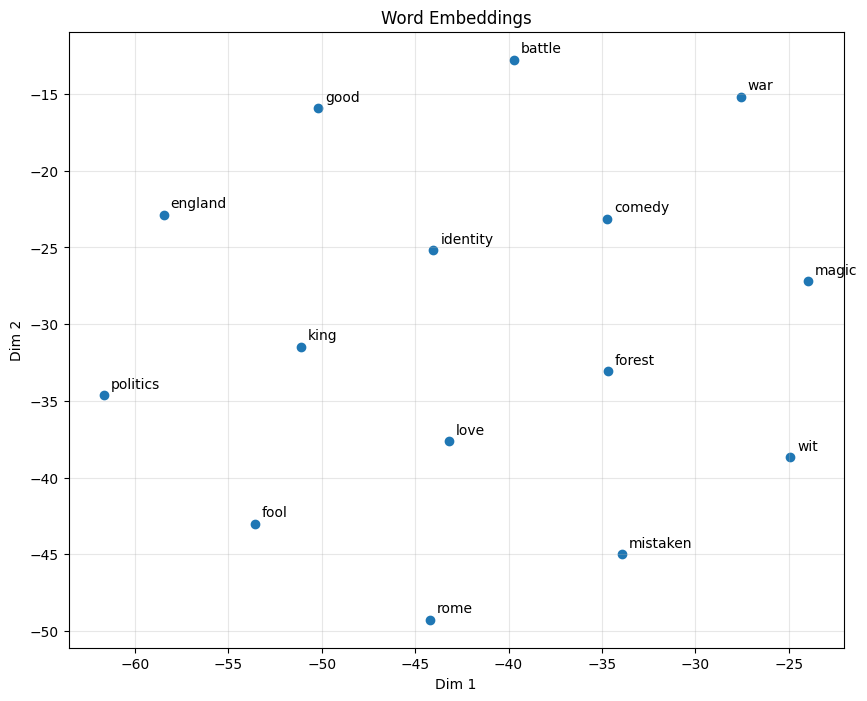

In [222]:
def visualize_embeddings(embeddings, labels):
  """Visualize high-dimensional embedding in two dimensions with t-Distributed Stochastic Neighbor Embedding"""

  # Reducing dimensionality to 2 with t-SNE
  if embeddings.shape[1] > 2 and embeddings.shape[0] > 5: # Checking that there are enough samples
    # Adjust perplexity based on number of samples
    ppl = min(30,embeddings.shape[0]-1) # 30 is the default, but must be < n_samples
    tsne = TSNE(n_components = 2, random_state=42, perplexity=ppl)
    embeddings_2d = tsne.fit_transform(embeddings)
  else:
    embeddings_2d = embeddings[:,:2] # Takes just 2 first dimensions

  print(embeddings_2d)

  plt.figure(figsize=(10,8))
  plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1])

  # Adding labels
  for i,label in enumerate(labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), xytext=(5, 5), textcoords='offset points')

  plt.title("Word Embeddings")
  plt.xlabel("Dim 1")
  plt.ylabel("Dim 2")
  plt.grid(True, alpha=.3)
  plt.show()

if ppmi_matrix.shape[0]>0:
  print("Visualizing word embeddings from PPMI matrix")
  embeddings = ppmi_matrix.values
  labels = ppmi_matrix.index.tolist()
  visualize_embeddings(embeddings, labels)